In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/IQ-OTH_NCCD lung cancer dataset.txt
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (246).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (155).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (311).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (45).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (298).jpg
/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (359).jpg
/kaggle/input/datasets/hamdallak/the-iqot

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries Imported Successfully!")

2026-02-25 20:15:14.305621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772050514.710929      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772050514.808429      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772050515.657061      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772050515.657101      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772050515.657104      24 computation_placer.cc:177] computation placer alr

Libraries Imported Successfully!


In [3]:
# Dataset er path (Kaggle dataset er structure onujayi)
base_path = '/kaggle/input/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']
filepaths = []
labels = []

for category in categories:
    path = os.path.join(base_path, category)
    for file in os.listdir(path):
        filepaths.append(os.path.join(path, file))
        labels.append(category.replace(' cases', '')) # 'Bengin', 'Malignant', 'Normal'

# DataFrame toiri
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Data split kora (Train 80%, Test 20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

print(f"Total Images: {len(df)}")
print(df['labels'].value_counts())

Total Images: 1097
labels
Malignant    561
Normal       416
Bengin       120
Name: count, dtype: int64


In [4]:
# Preprocessing function (Pixel value ke 0-1 er moddhe ana)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train, Validation and Test Generators
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=(150, 150),
    batch_size=32, class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=(150, 150),
    batch_size=32, class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=(150, 150),
    batch_size=32, class_mode='categorical', shuffle=False
)

Found 702 validated image filenames belonging to 3 classes.
Found 175 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [5]:
model = models.Sequential([
    # 1st Conv Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    
    # 2nd Conv Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # 3rd Conv Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Flatten & Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Overfitting komanor jonno
    layers.Dense(3, activation='softmax') # 3 ti class er jonno softmax
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1772050553.928874      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772050553.931817      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15, # Tumi dorkar hole barate paro
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1772050558.243135      70 service.cc:152] XLA service 0x792128006730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772050558.243175      70 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1772050558.243181      70 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1772050558.711045      70 cuda_dnn.cc:529] Loaded cuDNN version 91002


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:27 7s/step - accuracy: 0.5312 - loss: 1.0327

I0000 00:00:1772050563.463883      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.5123 - loss: 1.5965 - val_accuracy: 0.5429 - val_loss: 0.9192
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.5245 - loss: 0.9273 - val_accuracy: 0.5771 - val_loss: 0.8877
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.6425 - loss: 0.8436 - val_accuracy: 0.7429 - val_loss: 0.6330
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7435 - loss: 0.6132 - val_accuracy: 0.8229 - val_loss: 0.4890
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7823 - loss: 0.5510 - val_accuracy: 0.8171 - val_loss: 0.4307
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8297 - loss: 0.4283 - val_accuracy: 0.8971 - val_loss: 0.2701
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.8622 - loss: 0.3106 - val_accuracy: 0.9200 - val_loss: 0.2075
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9056 - loss: 0.2249 - val_accuracy: 0.9429 - val

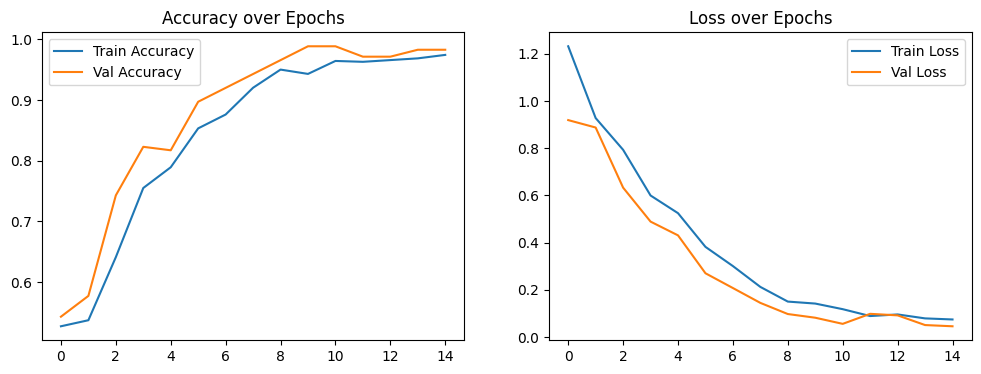

In [7]:
# Accuracy Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step


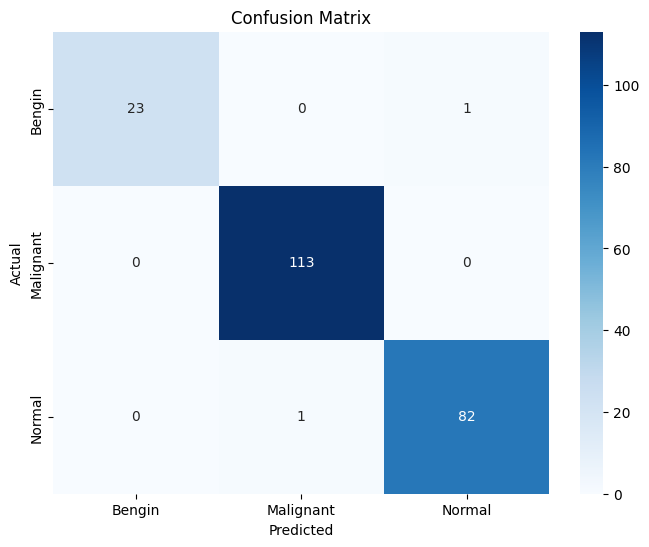

              precision    recall  f1-score   support

      Bengin       1.00      0.96      0.98        24
   Malignant       0.99      1.00      1.00       113
      Normal       0.99      0.99      0.99        83

    accuracy                           0.99       220
   macro avg       0.99      0.98      0.99       220
weighted avg       0.99      0.99      0.99       220



In [8]:
# Prediction
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))